**Use an API to extract box office revenue and profit data to add to your IMDB data and perform exploratory data analysis**

# Loading Imports

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Additional Imports
import os, json, math, time
from tqdm.notebook import tqdm_notebook
import tmdbsimple as tmdb

# Revenue extraction using APIs

In [2]:
with open('/Users/akinde.kadjo/.secret/tmbd_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['client-id', 'api-key'])

In [3]:
tmdb.API_KEY =  login['api-key']

In [4]:
FOLDER = "Data/"
os.listdir(FOLDER)

['akas.csv',
 'basics.csv',
 'cleaned_akas.csv.gz',
 'cleaned_basics.csv.gz',
 'cleaned_ratings.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'ratings.csv',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json']

In [5]:
def get_movie_with_rating(movie_id):
    """Adapted from source = https://github.com/celiao/tmbsimple"""
    #Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    
    #save the.info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    
    ## Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
           info['certification'] = c['certification']
    return info

In [6]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [11]:
# Load in the dataframe from project part 1 as basics:
basics = pd.read_csv('Data/cleaned_basics.csv.gz')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


In [12]:
#YEARS_TO_GET = list(range(2000, 2022, 1))
YEARS_TO_GET = [2000, 2001]
errors = [ ]

In [13]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    #start INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
    
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/1417 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/242 [00:00<?, ?it/s]

In [10]:
#Print a message reporting back the number of movie ids that caused an error
print(f"- Total errors: {len(errors)}")

- Total errors: 240


In [16]:
movie = tmdb.Movies('tt0848228')
movie.info()

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 226.694,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

In [17]:
movie = tmdb.Movies('tt0332280')
movie.info()

{'adult': False,
 'backdrop_path': '/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg',
 'belongs_to_collection': None,
 'budget': 29000000,
 'genres': [{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}],
 'homepage': 'http://www.newline.com/properties/notebookthe.html',
 'id': 11036,
 'imdb_id': 'tt0332280',
 'original_language': 'en',
 'original_title': 'The Notebook',
 'overview': "An epic love story centered around an older man who reads aloud to a woman with Alzheimer's. From a faded notebook, the old man's words bring to life the story about a couple who is separated by World War II, and is then passionately reunited, seven years later, after they have taken different paths.",
 'popularity': 75.146,
 'poster_path': '/rNzQyW4f8B8cQeg7Dgj3n6eT5k9.jpg',
 'production_companies': [{'id': 12,
   'logo_path': '/iaYpEp3LQmb8AfAtmTvpqd4149c.png',
   'name': 'New Line Cinema',
   'origin_country': 'US'},
  {'id': 1565, 'logo_path': None, 'name': 'Avery Pix', 'origin_country': 'US'},
  {'id': 26

# Exploratory Data Analysis

In [2]:
Data2000_df =pd.read_csv('Data/final_tmdb_data_2000.csv.gz')
Data2000_df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN


In [26]:
Data2000_df.shape

(1213, 26)

In [3]:
Data2001_df =pd.read_csv('Data/final_tmdb_data_2001.csv.gz')
Data2001_df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.324,1155.0,PG-13


In [25]:
Data2001_df.shape

(1294, 26)

In [4]:
combined_df = pd.concat([Data2000_df,Data2001_df])
combined_df.shape

(2507, 26)

In [33]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507 entries, 0 to 1293
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2507 non-null   object 
 1   adult                  2505 non-null   float64
 2   backdrop_path          1316 non-null   object 
 3   belongs_to_collection  196 non-null    object 
 4   budget                 2505 non-null   float64
 5   genres                 2505 non-null   object 
 6   homepage               176 non-null    object 
 7   id                     2505 non-null   float64
 8   original_language      2505 non-null   object 
 9   original_title         2505 non-null   object 
 10  overview               2455 non-null   object 
 11  popularity             2505 non-null   float64
 12  poster_path            2225 non-null   object 
 13  production_companies   2505 non-null   object 
 14  production_countries   2505 non-null   object 
 15  rele

### How many movies had at least some valid financial information?

In [32]:
#How many movies with valid financial information (values > 0 for budget AND revenue)?
financial_df2 = combined_df.loc[valid_budget & valid_revenue,: ]
financial_df2.shape

(351, 26)

In [5]:
#How many movies with valid financial information (values > 0 for budget OR revenue)?
valid_budget = combined_df['budget'] >0
valid_revenue = combined_df['revenue'] >0
financial_df = combined_df.loc[valid_budget | valid_revenue,: ]
financial_df.shape

(625, 26)

In [7]:
#How many movies with no valid financial information (values <= 0 for budget AND revenue)?
no_budget = combined_df['budget'] <=0
no_revenue = combined_df['revenue'] <=0
no_financial_df = combined_df.loc[no_budget & no_revenue,: ]
no_financial_df.shape

(1880, 26)

C:\Users\akinde.kadjo\AppData\Local\Temp\ipykernel_18500\1285730936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_df['finance_status'] = ['valid financial info']*len(financial_df)
C:\Users\akinde.kadjo\AppData\Local\Temp\ipykernel_18500\1285730936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_financial_df['finance_status'] = ['no valid financial info']*len(no_financial_df)


<AxesSubplot:xlabel='finance_status', ylabel='count'>

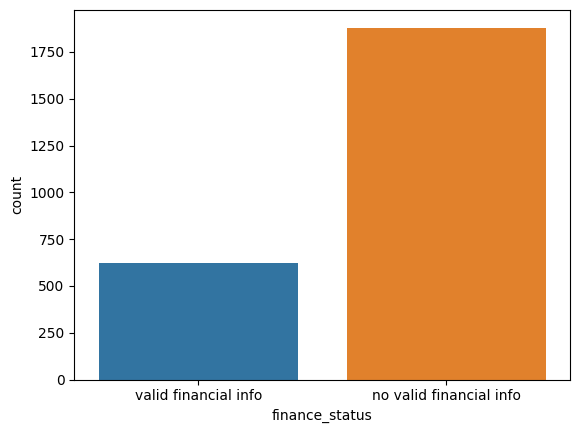

In [13]:
#Graph showing movies with valid financial information versus those that don't
financial_df['finance_status'] = ['valid financial info']*len(financial_df)
no_financial_df['finance_status'] = ['no valid financial info']*len(no_financial_df)
finance = pd.concat([financial_df,no_financial_df])
sns.countplot(x=finance['finance_status'])

### How many movies are there in each of the certification categories (G/PG/PG-13/R)?

In [38]:
financial_df.groupby('certification')['imdb_id'].count()

certification
G         14
NR        17
PG        36
PG-13    130
R        228
Name: imdb_id, dtype: int64

<AxesSubplot:xlabel='certification', ylabel='count'>

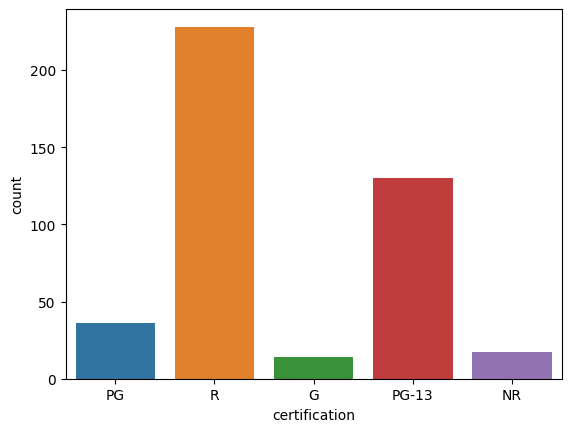

In [14]:
#Graph showing numbers of movies per certification categories
sns.countplot(x=financial_df['certification'])

In [39]:
#How many total have a certification category?
financial_df.groupby('certification')['imdb_id'].count().sum()

425

### What is the average revenue per certification category?

In [40]:
financial_df.groupby('certification')['revenue'].mean()

certification
G        1.237463e+08
NR       8.887619e+06
PG       1.092184e+08
PG-13    1.000266e+08
R        3.335293e+07
Name: revenue, dtype: float64

<AxesSubplot:xlabel='certification', ylabel='revenue'>

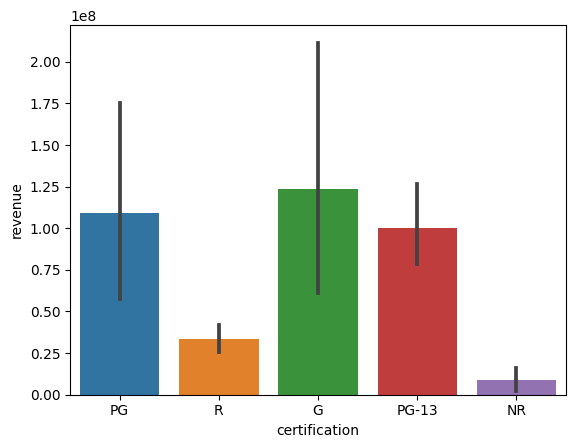

In [15]:
#Graph showing the average revenue per certification category
sns.barplot(data=financial_df, x='certification', y='revenue')

### What is the average budget per certification category?

In [41]:
financial_df.groupby('certification')['budget'].mean()

certification
G        4.085714e+07
NR       6.300006e+06
PG       4.372917e+07
PG-13    4.348391e+07
R        1.982239e+07
Name: budget, dtype: float64

<AxesSubplot:xlabel='certification', ylabel='budget'>

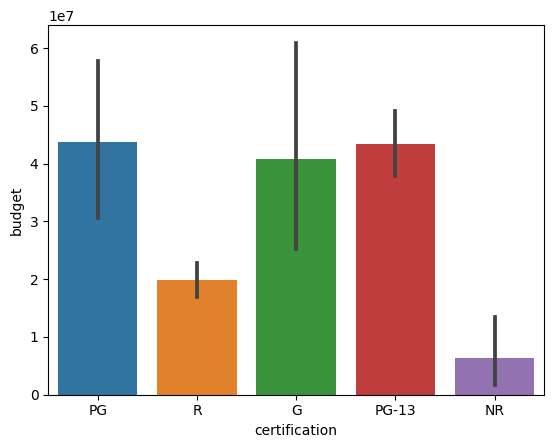

In [16]:
#Graph showing the average budget per certification category
sns.barplot(data=financial_df, x='certification', y='budget')

# Data Saving

In [43]:
financial_df.to_csv("Data/tmdb_results_combined.csv.gz", compression="gzip", index=False)